# Rapport
- Balthazar Neveu
- balthazarneveu@gmail.com
- [Lab 2 on github](https://github.com/balthazarneveu/MVA23_SIGNAL/tree/lab_2)

### Résumé
- précision = `68.8%` : Ultra-basique 1 caractéristique, 1 seuil
- précision = `80%`: Basique, 2 caractéristiques, arbre de décision de profondeur 4 (une grosse demi journée de travail)
- précision = `87.6%`: Random forest - 11 caractéristiques (~ une autre grosse demi journée de travail)
> La progression en précision du détecteur n'est **malheureusement pas linéaire** avec le temps de travail passé sur le sujet!


J'ai rapatrié tout le code des fonctions écrite à l'occasion dans le notebook.

In [ ]:
!pip install xgboost
# Did a few tests with xgboost as it's a very popular library for ML ... 
# the mere difference with sklearn decisions trees and ada boost does not truly justify using xgboost... 
# still - why not trying if it could improve for free?

In [184]:
import numpy as np
import sklearn as skl
import json
import pandas as pd
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from pathlib import Path
from typing import List, Dict, Tuple, Any, Union
import scipy

# from utilities import homogenize_dataset, get_hand_crafted_features, ALL_CLASSIFIERS, train_classifier, get_better_features, extract_peaks, whiten, display_confusion_matrix
# from utilities import final_classification_plots, ALL_CLASSIFIERS, DECISION_TREE, RANDOM_FOREST, SVM, ADABOOST, XG_BOOST
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
# DATA "UNIFORMIZATION" -> sample all signals on a regular timeline 
# Regular timeline = 10 seconds with 100 elements (we may get a bit of aliasing)
# Then we may navigate this data as a regular data structure (could fit in an excel).
# timestamps are now exactly the same for all signals.


# - la date de début de détection de l'impulsion (en ms)
# - la largeur ou durée de l'impulsion (en ms)
# - la puissance de l'impulsion (en dB / référence) 
# - l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
# - la fréquence de l'impulsion (en Ghz)

def homogenize_dataset(dataset="train", data_path = Path("radars"), num_samples=100) -> pd.DataFrame:
    """This function is used to normalize and standardize a dataset.
    It converts non-uniformly sampled signals into a regular timeline
    and normalizes the values to standard units.
    The resulting DataFrame is easier to work with for further data analysis or machine learning tasks.
    Note: we may loose information due to resampling / get some aliasing.

    Parameters:
    dataset (str): The dataset to be homogenized. Default is "train".
    data_path (Path): The path to the directory containing the dataset. Default is "radars".
    num_samples (int): The number of samples to be used for the regular timeline. Default is 100. 
    
    Note on num_samples:
    Downsampling may introduce some aliasing... which may not be optimal for peaks detection.
    Empirically, it simplified the tuning of the peak detector
    A correct signal denoiser like a bilateral filter could be a better solution.

    Returns:
    DataFrame: A pandas DataFrame containing the homogenized dataset.
    """
    data = []
    values_units = [
        ("largeur", 1.E-3),
        ("frequence",1.E9),
        ("puissance" ,1.),("theta", 1.),
        ("phi", 1.)
    ]
    with open(data_path/f'{dataset}_labels.json') as f:
        dict_labels_current = json.load(f)
    for idx in range(799):
        pdws = np.load(data_path/ dataset / f'pdw-{idx}.npz')
        target = dict_labels_current[f'pdw-{idx}']=="nonmenace"
        dates = pdws['date']
        uniform_timestamps = np.linspace(0, 10.E3, num_samples)
        new_dic = {}
        for label, scale in values_units: #normalize to standard units (Hz, seconds)
            non_uniform_value = pdws[label]
            regular_sampling = np.interp(uniform_timestamps, xp=dates, fp=non_uniform_value)
            new_dic[label] = regular_sampling*scale
        new_dic["menace"] = not target
        diff_ts  =(dates[1:]-dates[:-1])/1000.
        new_dic["timestamps_interval_multiples"] = np.round(diff_ts/np.min(diff_ts))
        new_dic["impulsion_freq"] = 1./np.min(diff_ts)
        data.append(new_dic)
    df = pd.DataFrame.from_dict(data)
    return df


# "HANDCRAFTED" BASIC FEATURE COMPUTATION
def get_hand_crafted_features(df: pd.DataFrame, feature_dimension=None) -> Tuple[List, List]:
    inv_freq_mean = np.array([(1./el).mean() for el in df["frequence"]])
    freq_feature = np.array([(1./el).std()/((1./el).mean()) for el in df["frequence"]])
    min_pow = np.array([el.min() for el in df["puissance"]])
    largeur_mean = np.array([el.mean() for el in df["largeur"]])
    freq_std = np.array([el.std() for el in df["frequence"]])
    std_pow = np.array([el[20:50].std() for el in df["puissance"]])
    x = np.stack([freq_std, min_pow, std_pow, freq_feature, inv_freq_mean, largeur_mean], axis=1)
    if feature_dimension is not None:
        x=x[:, :feature_dimension]
    y = [1. if el else 0. for el in df["menace"]]
    return x, y

def extract_peaks(df: pd.DataFrame, add_to_df :bool=False) -> Tuple[List, List]:
    for under_flag, prefix in [(True, "under_"), (False, "")]:
        peaks_locations_list = []
        peaks_values_list = []
        for idx in range(len(df)):
            # if df_hard.menace[idx]:
            peaks = scipy.signal.find_peaks((-1 if under_flag else 1.)*df.puissance[idx])[0]
            peaks_locations_list.append(peaks)
            peaks_values_list.append(df.puissance[idx][peaks])
        if add_to_df:
            df[prefix+"peaks_loc"] = peaks_locations_list
            df[prefix+"peaks_val"] = peaks_values_list
    return peaks_locations_list, peaks_values_list

In [186]:
DECISION_TREE = "Decision tree"
SVM = "SVM classifier"
RANDOM_FOREST = "Random forest"
ADABOOST = "Ada Boost"
XG_BOOST = "XG Boost"
ALL_CLASSIFIERS = [DECISION_TREE, SVM, RANDOM_FOREST, ADABOOST]
def train_classifier(
        x_train, x_test, y_train, y_test,
        feature_dimension=3,
        debug=False, show=True, forced_depth=None,
        classifier=DECISION_TREE,
    ) -> Tuple[np.ndarray, int]:
    COLOR_LIST = "rgbckyp"
    if feature_dimension is None:
        x_train_shrink, x_test_shrink = x_train, x_test 
    else:
        x_train_shrink, x_test_shrink = x_train[:, :feature_dimension], x_test[:, :feature_dimension]
    accuracies = []
    confusion_matrices = []
    
    classifiers = []
    if classifier == DECISION_TREE or classifier == RANDOM_FOREST:
        depth_list = list(range(1, 10))
        for depth in depth_list:
            if classifier == DECISION_TREE:
                dt = DecisionTreeClassifier(max_depth=depth)
            else:
                dt = RandomForestClassifier(max_depth=depth, n_estimators=10, max_features=1, random_state=73)
            dt.fit(x_train_shrink, y_train)
            classifiers.append(dt)
            y_train_pred = dt.predict(x_train_shrink)
            y_test_pred = dt.predict(x_test_shrink)
            acc_train, acc_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
            accuracies.append([acc_train, acc_test])
            confusion_matrices.append(sk_confusion_matrix(y_test, y_test_pred))
            # if debug:
            #     print(f"accuracy training {acc_train:.1f} | accuracy test {acc_test:.1f}")
    elif classifier in [SVM, ADABOOST, XG_BOOST]:
        depth_list = [1]
        best_depth = 0
        extra = {}
        if classifier == SVM:
            # clas = SVC(kernel="rbf", C=1.)
            clas = SVC(kernel="poly", degree=5, C=1.)
        elif classifier == ADABOOST:
            clas = AdaBoostClassifier(n_estimators=50)
        elif classifier == XG_BOOST:
            import xgboost as xgb
            clas = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, )
            extra = {"eval_set":[(x_test_shrink, y_test)], "verbose": 0}
        clas.fit(x_train_shrink, y_train, **extra)
        classifiers.append(clas)
        y_train_pred = clas.predict(x_train_shrink)
        y_test_pred = clas.predict(x_test_shrink)
        acc_train, acc_test = accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)
        accuracies.append([acc_train, acc_test])
        confusion_matrices.append(sk_confusion_matrix(y_test, y_test_pred))
        
    else:
        raise NotImplementedError(f"Classifier {classifier} not implemented")
    accuracies = np.array(accuracies)
    if debug:
        col=COLOR_LIST[(feature_dimension-1)%len(COLOR_LIST)]
        plt.plot(depth_list, accuracies[:, 0], "--"+col, alpha=0.7, label=f"accuracy train #{feature_dimension} features")
        plt.plot(depth_list, accuracies[:, 1], "-"+col, alpha=0.7, label=f"accuracy test #{feature_dimension} features")
        plt.legend()
        plt.xlabel("Depth of the decision tree")
        plt.ylabel("Classifier accuracy")
        if show:
            plt.grid()
            plt.show()
    
    best_depth = np.argmax(accuracies[:, 1]) if forced_depth is None else forced_depth
    return accuracies[best_depth, :], depth_list[best_depth], classifiers[best_depth], confusion_matrices[best_depth]


def display_confusion_matrix(confusion_matrix):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix.ravel()
    print(f"{true_negative=} non-menace samples were classified as non-menaces")
    print(f"{false_positive=} non-menaces were classified as menaces (False alarm)")
    print(f"{false_negative=} menaces were classified as non-menaces (problem = you're under attack and you didn't realize)")
    print(f"{true_positive=} menaces were classified as menaces correctly (you're under attack and you have detected it)")


Commençons par une première passe d'homogénéisation du jeu de donnée. 

En effet, l'échantillonnage temporal n'est pas régulier... l'horodatage n'est pas le même pour tous les signaux.

Afin de simplifier la visualisation et le travail sur les données, nous allons simplement ré-échantillonner le tout (timestamps réguliers, échantillonnage à 10HZ).

Chaque signal aura 100 échantillons ce qui permet d'avoir un volume raisonnable et même de supperposer les différents signaux pour les comparer.

In [187]:
num_samples = 100
df = df_train = homogenize_dataset(dataset="train", num_samples=num_samples)
df_test = homogenize_dataset(dataset="test", num_samples=num_samples)
extract_peaks(df_train, add_to_df=True)
extract_peaks(df_test, add_to_df=True)
df.head()


,largeur,frequence,puissance,theta,phi,menace,timestamps_interval_multiples,impulsion_freq,under_peaks_loc,under_peaks_val,peaks_loc,peaks_val
0,"[0.00029099999999999997, 0.0002911010187641941...","[2222011346.301772, 2201167919.9721026, 221708...","[-125.58248735699023, -115.0846158693843, -108...","[0.9578859532471261, 0.8703978859546783, 0.607...","[1.678935775441994, 1.7243409379102963, 1.6140...",False,"[16.0, 8.0, 20.0, 26.0, 12.0, 1.0, 26.0, 4.0, ...",677.048070,"[4, 7, 9, 11, 15, 19, 23, 28, 32, 37, 42, 47, ...","[-141.06251604140348, -137.31479891372942, -14...","[2, 6, 8, 10, 13, 16, 21, 25, 30, 35, 40, 45, ...","[-108.21630369700614, -129.064810778739, -136...."
1,"[0.00013800000000000002, 0.0001369258365512231...","[3011221070.570557, 2996006530.9250755, 300603...","[-127.176799666022, -157.8781625154061, -137.9...","[2.7962717807754327, -2.829550985701179, -2.48...","[1.5296932038533972, 1.5546468454693552, 1.632...",False,"[17.0, 6.0, 7.0, 10.0, 2.0, 35.0, 25.0, 55.0, ...",1092.896175,"[1, 8, 10, 17, 23, 30, 42, 49, 55, 61, 63, 69,...","[-157.8781625154061, -168.09173000783363, -157...","[3, 9, 13, 20, 27, 36, 45, 51, 58, 62, 66, 72,...","[-134.28594495282678, -156.43742404333207, -14..."
2,"[0.000201, 0.0002018786859303869, 0.000201, 0....","[991990464.3038368, 982743904.1435359, 9898809...","[-149.880060930416, -151.7229884218102, -153.5...","[-2.0412578355641227, -1.9204468635231988, -1....","[1.6722396416013094, 1.7759924411327765, 1.509...",True,"[15.0, 5.0, 3.0, 1.0, 2.0, 41.0, 1.0, 20.0, 13...",634.517766,"[5, 9, 13, 17, 21, 24, 28, 31, 35, 38, 42, 45,...","[-183.91728522138138, -172.661412654641, -178....","[7, 11, 15, 19, 22, 26, 30, 33, 37, 40, 44, 47...","[-160.1894729112234, -163.2840780476702, -165...."
3,"[6.800000000000001e-05, 6.928607233324905e-05,...","[1666424017.2021985, 1668061021.2198102, 16641...","[-135.68775777002037, -134.56670065032353, -13...","[-2.621701006244045, -2.2862588398101207, -2.1...","[1.4039557266900524, 1.6190396944122287, 1.690...",False,"[16.0, 3.0, 2.0, 2.0, 8.0, 15.0, 6.0, 23.0, 10...",1466.275660,"[7, 10, 16, 21, 27, 37, 47, 56, 66, 75, 84, 94]","[-140.3923586839108, -142.95012556664386, -164...","[1, 8, 11, 20, 22, 32, 42, 52, 62, 71, 83, 85,...","[-134.56670065032353, -140.1700103525957, -142..."
4,"[0.000324, 0.0003248032831089071, 0.0003248041...","[2207809393.1871147, 2200771938.7002068, 22022...","[-172.60362010919195, -151.87364054688302, -15...","[2.274032092616462, 2.127649080211378, 2.36297...","[1.6134753329852611, 1.6012352706627135, 1.745...",False,"[17.0, 1.0, 4.0, 5.0, 25.0, 27.0, 1.0, 21.0, 2...",604.960678,"[3, 6, 11, 20, 30, 34, 43, 52, 62, 71, 80, 89]","[-157.9410015786667, -173.03619066421422, -162...","[1, 5, 7, 12, 25, 32, 38, 48, 57, 65, 76, 85, 95]","[-151.87364054688302, -151.5424503909395, -155..."


## Phase exploratoire
On commence par chercher des critères simples (statistiques basiques des signaux)  pour classifier les données.

### Min puissance
- Si on fait défiler les signaux de puissance en figeant l'échelle verticale, nous remarquons clairement un "paquet" au dessus des autres.
- Un descripteur très simple pour discriminer la menace correspond au mimimum de la puissance. On sait déjà qu'il n'est pas suffisant (au vu du gros "paquet" vert et rouge)

![](figures/superposition_signaux_puissance.png)


### Moyenne et puissance des fréquences

- L'étude de l'évolution temporelle des fréquences ne révèle pas de fluctuations perceptibles (signaux stationnaires).

![](figures/superposition_signaux_frequence.png)

- On peut simplement évaluer les moments et ainsi tracer la distribution moyenne des fréquences ainsi que l'écart type



En poussant un peu l'étude manuelle des caractéristiques, on commence à arriver à distinguer quelques groupes:
- écart type(1/fréquence)/moyenne(1/fréquence)
- min(puissance)

![](figures/x=freq_avg_y=freq_std_div_freq_avg.png)


Un arbre de décision devrait permettre de classifier les données (partitionner l'espace en plusieurs rectangles).


## Classification basique
Une approche rationnelle consiste à aggréger les caractéristiques et entraîner un classifieur simple (arbre de décisions) en jouant sur sa profondeur.
Plus on ajoute de caractéristiques, plus on espère que la précision du modèle augmente


![decision_tree](figures/decision_tree.png)

- Avec une unique caractéristique (bien choisie) et un unique seuil, nous atteignons 70% de précision.
- En augmentant la profondeur de l'arbre de décision jusqu'à 4, nous atteignons une précision de 75%
- Avec 2 caractéristiques, nous remarquons qu'il est nécessaire d'avoir une profondeur de 4 sur l'arbre de décision afin d'atteindre la précision optimale.
- Nous remarquons qu'au delà d'une profondeur de 6, l'arbre de décision est à la limite de "sur-apprentissage" (la précision sur la base d'entraînement augmente alors que la précision de validation stagne ou commence à diminuer.)

### Basic classifier

In [188]:
# Define the training and testing sets by extracting the features from the dataframes.
x_train, y_train = get_hand_crafted_features(df_train)
x_test, y_test = get_hand_crafted_features(df_test)

### Ultra-simplistic classifiers
Une unique unique caractéristique

In [189]:
feature_dimension=1
accuracies, _, _, confusion_matrix = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=1, forced_depth=feature_dimension, debug=False,  show=False)
print(f"#features={feature_dimension} Tree depth={1} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
print(f"Confusion matrix:\n{confusion_matrix}")
display_confusion_matrix(confusion_matrix)

#features=1 Tree depth=1 accuracy training 71.1% | accuracy test 68.8%
Confusion matrix:
[[178 236]
 [ 13 372]]
true_negative=178 non-menace samples were classified as non-menaces
false_positive=236 non-menaces were classified as menaces (False alarm)
false_negative=13 menaces were classified as non-menaces (problem = you're under attack and you didn't realize)
true_positive=372 menaces were classified as menaces correctly (you're under attack and you have detected it)


#### Analyse de la matrice de confusion du détecteur **ultra-basique**
Avec le détecteur ultra basique mono-caractéristique permettant d'arriver à 68.8% de précision.
- 236/800 faux positifs signifie qu'on sonne l'alarme pour rien (le système est paranoïaque!)
- 13/800 faux négatifs signifie qu'on ne s'est pas rendu du compte qu'on était menacé...

La précision ne reflète en aucun cas ce  manque d'équilibre. Il serait intéressant lorsqu'on va chercher à améliorer le détecteur
d'essayer d'avoir moins de faux négatifs... 

# Amélioration du détecteur basique

Ajoutons d'autres caractéristiques mentionnées précédemment et découvertes par tatonnement et intuition visuelle.

Cette pratique de conception de caractéristiques manuelle ("handcrafted features" en machine learning) est assez lourde.
- On espère utiliser des corrélations observées à l'oeil lorsqu'on a visualisé les signaux.
- Idéalement, on aimerait que le phénomène physique sous-jacent appuie la conception des features. 

> C'est la première fois que je m'essaie au problème et ce n'est pas facile (et fastidieux!)

#features=1 Tree depth=4 accuracy training 76.3% | accuracy test 75.7%
[[402  12]
 [182 203]]
#features=2 Tree depth=4 accuracy training 80.2% | accuracy test 80.0%
[[414   0]
 [160 225]]
#features=3 Tree depth=4 accuracy training 80.2% | accuracy test 80.0%
[[414   0]
 [160 225]]
#features=4 Tree depth=4 accuracy training 80.2% | accuracy test 80.0%
[[414   0]
 [160 225]]


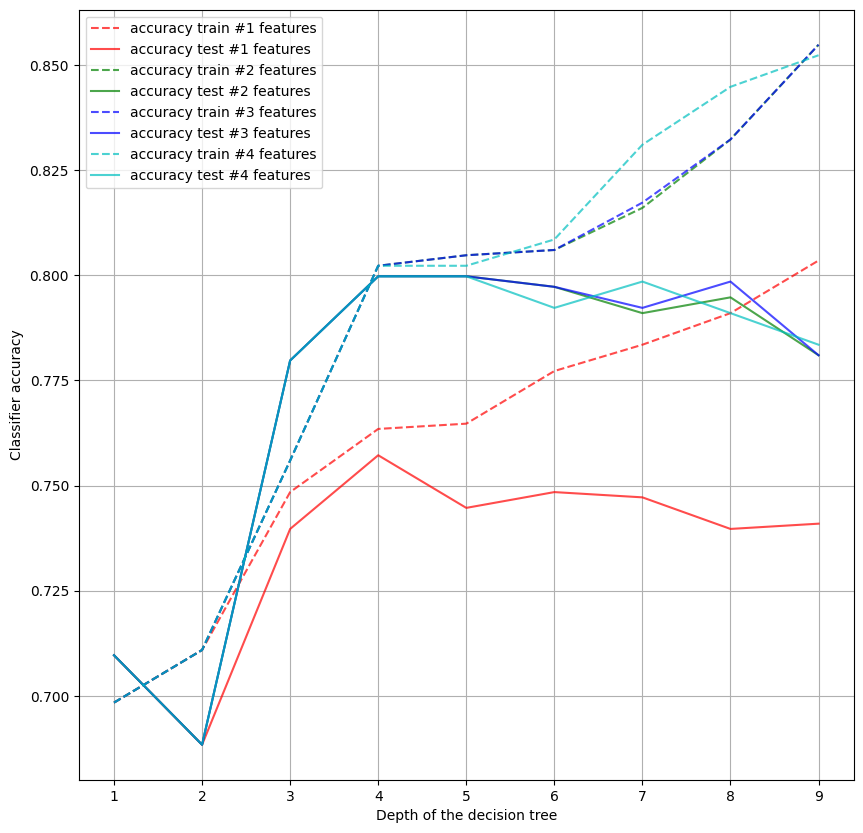

true_negative=414 non-menace samples were classified as non-menaces
false_positive=0 non-menaces were classified as menaces (False alarm)
false_negative=160 menaces were classified as non-menaces (problem = you're under attack and you didn't realize)
true_positive=225 menaces were classified as menaces correctly (you're under attack and you have detected it)


In [190]:
compare_plots = True
plt.figure(figsize=(10, 10))
for feature_dimension in range(1, 5):
    accuracies, best_depth, _, confusion_matrix = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=True,  show=not compare_plots)
    print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
    print(confusion_matrix)
if compare_plots:
    plt.grid()
    plt.show()

display_confusion_matrix(confusion_matrix)

### Analyse de la matrice de confusion du détecteur **basique**
Avec la détecteur amélioré permettant d'obtenir 80% de précision:
- 160/800 faux négatifs signifie qu'on ne s'est pas rendu du compte qu'on était menacé...**Ceci est problématique**
- 0/800 faux positifs signifie qu'on ne sonne pas l'alarme pour rien (le système n'est pas paranoïaque!)

La précision ne reflète en aucun cas ce  manque d'équilibre. Il serait intéressant lorsqu'on va chercher à améliorer le détecteur
d'essayer d'avoir moins de faux négatifs... 

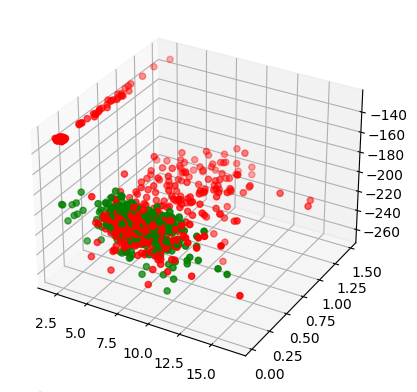

In [191]:
colors = ["r" if el else "g" for el in df["menace"]]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train[:, 2], x_train[:, 0], x_train[:, 1], color=colors)
plt.show()


Difficile de séparer cet amas de points verts et rouge... 
il faut trouver de nouvelles caractéristiques pour aller plus loin.

# Analyzing the time series

Let's first retieve some remaining "difficult" signals to classify.

In [192]:
features_to_keep = 4
accuracies, best_depth, classifier, confusion_matrix = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=features_to_keep, debug=False,  show=False, forced_depth=4)
y_train_pred = classifier.predict(x_train[:, :features_to_keep])
missclassified_indexes = np.where(y_train_pred!=y_train)[0]
display_confusion_matrix(confusion_matrix)


true_negative=414 non-menace samples were classified as non-menaces
false_positive=0 non-menaces were classified as menaces (False alarm)
false_negative=160 menaces were classified as non-menaces (problem = you're under attack and you didn't realize)
true_positive=225 menaces were classified as menaces correctly (you're under attack and you have detected it)


In [193]:
all_indexes = df.index.values
# Get indexes that are not in missclassified_indexes
not_missclassified_indexes = np.setdiff1d(all_indexes, missclassified_indexes)

# Generate
num_indexes_to_choose = 100  # specify the number of indexes you want
random_indexes = np.random.choice(not_missclassified_indexes, num_indexes_to_choose, replace=False)
df_random = df.take(random_indexes).copy().reset_index()

In [194]:
df_hard = df.take(missclassified_indexes).copy()
df_hard.reset_index(inplace=True)

In [195]:
# Here we only have menaces which were missclassified ...
df_hard.menace.sum()/len(df_hard)

1.0

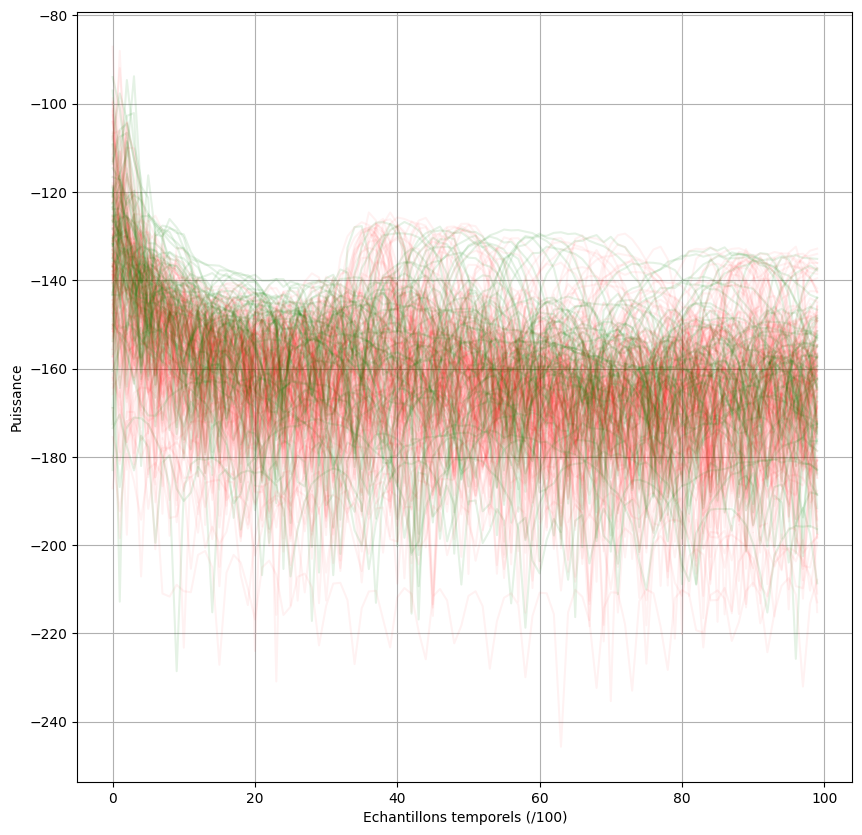

In [196]:
plt.figure(figsize=(10, 10))
plt.plot(np.array([df_hard.puissance[idx] for idx in range(len(df_hard)) if df_hard.menace[idx]]).T, "r", alpha=0.05, label="menace")
plt.plot(np.array([df_hard.puissance[idx] for idx in range(len(df_hard)) if not df_hard.menace[idx]]).T, "g", alpha=0.1, label="safe")
plt.plot(np.array([df_random.puissance[idx] for idx in range(len(df_random)) if not df_random.menace[idx]]).T, "g", alpha=0.1, label="safe")
plt.grid()
plt.ylabel("Puissance")
plt.xlabel("Echantillons temporels (/100)")
plt.show()

- A noter que depuis qu'on a enlevé le faisceaux de courbes qui était au dessus (à l'aide du seuil sur le min des puissances)...la distinction menace/non menace devient plus difficile!
- Très difficile d'observer un motif particulier ici à part que quelques gros lobes se distinguent du reste. On a de toute façon envie d'étudier les lobes car il n'y a plus vraiment d'autres "easy win" à étudier d'après moi.
- On peut utiliser la méthode `scipy.signal.find_peaks` clé en main afin de détecter les pics.
- Etant donné que le signal a été sous échantillonné (100 échantillons réguliers), le signal a l'air faussement peu bruité. Il est important de noter que ceci n'est qu'une impression... les pics sont peut être moins précis. 
> Idéalement : Faire les choses très proprement nécessiterait de mettre en place un débruitage travaillant sur le signal original non décimé, préservant les contours (un simple bilatéral) avant de détecter les pics...

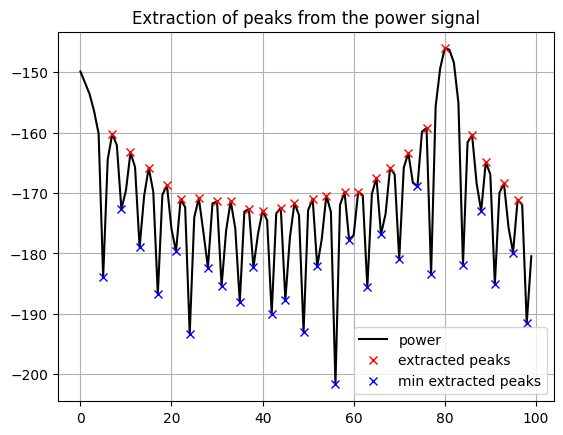

In [197]:
peaks_min, _props =  scipy.signal.find_peaks(-df_hard.puissance[0])
peaks, props =  scipy.signal.find_peaks(df_hard.puissance[0])
plt.plot(df_hard.puissance[0], "k-", label="power")
plt.plot(peaks, df_hard.puissance[0][peaks], "xr", label="extracted peaks")
plt.plot(peaks_min, df_hard.puissance[0][peaks_min], "xb", label="min extracted peaks")
plt.grid()
plt.title("Extraction of peaks from the power signal")
plt.legend()
plt.show()
# np.average(peaks[1:] - peaks[:-1])

On peut alors essayer de **compter le nombre de pics** afin de voir si c'est un critère discriminant. Il semble que oui au vu des histogrammes.
> Cette caractéristique sera incorporée dans le détecteur amélioré

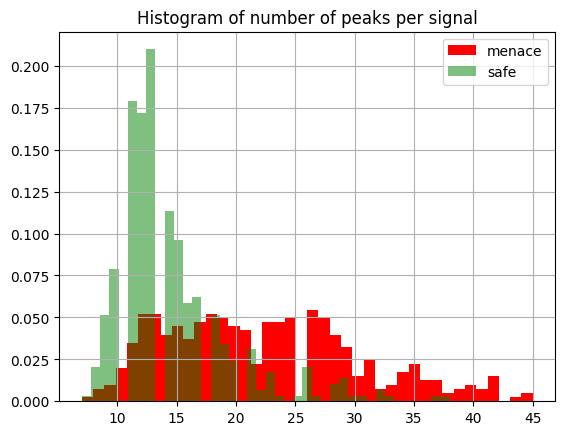

In [198]:
peaks, peak_vals = extract_peaks(df, add_to_df=True)
plt.hist([len(el) for idx, el in enumerate(df.peaks_loc) if df.menace[idx]], color="r", bins=40, label="menace", density=True)
plt.hist([len(el) for idx, el in enumerate(df.peaks_loc) if not df.menace[idx]], color="g", bins=40, alpha=0.5, label="safe", density=True)
plt.title("Histogram of number of peaks per signal")
plt.grid()
plt.legend()
plt.show()

Enfin, j'ai essayé d'exploiter les données des horodatages... par exemple en regardant l'histogramme des fréquences entre les impulsions. (j'enlève les paquets perdus lors de la création des `impulsion_freq`) 

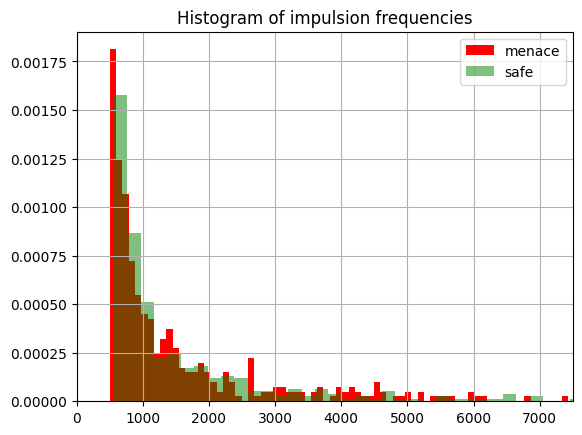

In [199]:
plt.hist([el for idx, el in enumerate(df.impulsion_freq) if df.menace[idx]], color="r", bins=100, label="menace", density=True)
plt.hist([el for idx, el in enumerate(df.impulsion_freq) if not df.menace[idx]], color="g", bins=100, alpha=0.5, label="safe", density=True)
plt.title("Histogram of impulsion frequencies")
plt.grid()
plt.xlim(0, 7500)
plt.legend()
plt.show()

# Amélioration finale du détecteur
- Le premier point important à remarquer, c'est que l'on part d'une baseline à 80% à l'aide d'un arbre de décision sur 3 caractéristiques, obtenu grosso modo en une demi journée de travail.
- Ajouter les données temporelles (analyse de pics) m'a permis de passer à 85% en une heure de travail sur le sujet (commit du 2 novembre).
- Pour arriver au résultat final et gratter 3% de précision, c'est une grosse demi journée de travail supplémentaire.
![](figures/git_tree.png)

- Pour arriver au résultat final et pour "gratter" jusqu'à 87.6%, il aura fallu explorer pas mal de pistes:
  - tester différents détecteurs:
    - arbres de décision, random forest
    - SVM qui marchent mal lorsqu'on ne normalise pas les caractéristiques
    - *essayer xGBoost reconnu comme l'un des plus performants*...
  - rationnaliser le tout, tout mettre sous forme de fonctions avec (utilisation de dictionnaires permettant d'itérer facilement avec des caractéristiques nommées, commits fréquents pour tracker les performances et pouvoir revenir en arrière si régression).
  - ajout de la "normalisation" des caractéristiques (centrage de la moyenne sur la base d'entraînement en 0 et écart type =1 pour chaque feature).
  - tentatives d'incorporation de contraintes sur la physique - pas vraiment de succès.

On trouvera 
- tout le code d'extraction des caractéristiques dans `get_better_features`
- le code d'entraînement du détecteur `train_classifier` fortement basé sur scikit learn


In [200]:
# BETTER "HANDCRAFTED" FEATURE COMPUTATION
def get_better_features(df: pd.DataFrame, feature_dimension=None) -> Tuple[List, List]:
    # theta=np.array([np.mean(el) for el in df["theta"]]),
    # phi=np.array([np.mean(el) for el in df["phi"]]),
    # Not informative

    freq_mean = np.array([el.mean() for el in df["frequence"]])
    light_speed_c = 3.E8
    wave_length_lambda= light_speed_c/freq_mean
    power = np.array([10.**(el.mean()/10.) for el in df["puissance"]])

    peak_mean_width = np.array([np.mean(el[1:] - el[:-1]) for el in df["peaks_loc"]])
    peak_max_width = np.array([np.max(el[1:] - el[:-1]) for el in df["peaks_loc"]])
    peak_median_width = np.array([np.median(el[1:] - el[:-1]) for el in df["peaks_loc"]])

    under_peak_mean_width = np.array([np.mean(el[1:] - el[:-1]) for el in df["under_peaks_loc"]])
    under_peak_max_width = np.array([np.max(el[1:] - el[:-1]) for el in df["under_peaks_loc"]])
    under_peak_median_width = np.array([np.median(el[1:] - el[:-1]) for el in df["under_peaks_loc"]])

    feature_dict = dict(
        freq_feature = np.array([(1./el).std()/((1./el).mean()) for el in df["frequence"]]),
        freq_mean = freq_mean,
        min_power_db = np.array([el.min() for el in df["puissance"]]),
        number_of_peaks = np.array([len(el) for el in df["peaks_loc"]]),
        
        freq_std = np.array([el.std() for el in df["frequence"]]),
        #Try to put a bit of physics in the features...
        power= power,
        distance_target = (power)**(-1/2.) * wave_length_lambda,
        distance_target_basic = (power)**(-1/2.),
        
        # mean_power = np.array([el.mean() for el in df["puissance"]]),
        std_power = np.array([el.std() for el in df["puissance"]]),

        
        
        # impulse_freq_sq=df.impulsion_freq**2,
        peak_mean_width = peak_mean_width,
        peak_max_width = peak_max_width,
        peak_median_width = peak_median_width,
        peak_ratio = peak_max_width/peak_median_width,


        under_peak_mean_width = under_peak_mean_width,
        under_peak_max_width = under_peak_max_width,
        under_peak_median_width = under_peak_median_width,

        peak_vals_std = np.array([np.std(el) for el in df["peaks_val"]]),
        impulse_freq=df.impulsion_freq,
        impulse_period=1./df.impulsion_freq,
        peak_vals_mean = np.array([np.mean(el) for el in df["peaks_val"]]),
    )
    # ts_multiples = np.array([np.quantile(el, 0.9) for el in df["timestamps_interval_multiples"]])
    # x = np.stack([freq_std, min_pow, peak_len, 1./impulse_freq, peak_width, peak_vals_std, peak_vals_mean], axis=1)
    x = np.stack([el for _, el in feature_dict.items()], axis=1)
    
    if feature_dimension is not None:
        x=x[:, :feature_dimension]
    y = [1. if el else 0. for el in df["menace"]]
    return x, y, list(feature_dict.keys())

#### WHITENING OF FEATURES
def estimate_whitening_coeffs(x:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    return np.mean(x, axis=0), np.std(x, axis=0)

def whiten(x:np.ndarray, mean=None, stddev=None) -> np.ndarray:
    if mean is None and stddev is None:
        mean, stddev = estimate_whitening_coeffs(x)
    whitened_x = (x-mean)/stddev
    # print(np.mean(x, axis=0), np.std(x, axis=0))
    return whitened_x, mean, stddev


#### FINAL CLASSIFICATION PLOTS
def final_classification_plots(
    df_training, df_testing,
    whiten_flag=False,
    classifiers_list = [XG_BOOST,  DECISION_TREE, RANDOM_FOREST, ADABOOST, SVM]
    ):
    x_train, y_train, labels_features = get_better_features(df_training)
    x_test, y_test, _ = get_better_features(df_testing)
    if whiten_flag:
        x_train, mean, stddev = whiten(x_train)
        x_test, _, _ = whiten(x_test, mean=mean, stddev=stddev)

    COLOR_LIST = "rgbckyp"
    best_accuracies_overall = []
    best_feature_dimensions = []
    best_confusion_matrix_overall = []
    # classifiers_list = ALL_CLASSIFIERS #[DECISION_TREE, RANDOM_FOREST, SVM, ADABOOST]
    # classifiers_list = [SVM]
    
    scanned_feature_dimension = list(range(1, len(labels_features)+1))
    plt.figure(figsize=(10, 10))
    for classifier_index, classifier_type in enumerate(classifiers_list):
        best_accuracies = []
        feature_dimensions = []
        confusion_matrices = []
        color = COLOR_LIST[classifier_index%len(COLOR_LIST)]
        for feature_dimension in scanned_feature_dimension:
            accuracies, best_depth, _, confusion_matrix = train_classifier(x_train, x_test, y_train, y_test, feature_dimension=feature_dimension, debug=False,  show=False, classifier=classifier_type)
            # print(f"#features={feature_dimension} Tree depth={best_depth} accuracy training {accuracies[0]*100:.1f}% | accuracy test {accuracies[1]*100:.1f}%")
            best_accuracies.append(accuracies)
            feature_dimensions.append(feature_dimension)
            confusion_matrices.append(confusion_matrix)
        plt.plot(feature_dimensions, 100.*np.array(best_accuracies)[:, 0], color+"--", alpha=0.1) #label=f"{classifier_type} accuracy training")
        plt.plot(feature_dimensions, 100.*np.array(best_accuracies)[:, 1], color+"-+") #label=f"{classifier_type} accuracy validation")
        best_index = np.argmax(np.array(best_accuracies)[:, 1])
        best_accuracy = best_accuracies[best_index][1]
        best_confusion_matrix = confusion_matrices[best_index]
        best_feature_dimension = feature_dimensions[best_index]
        plt.plot(feature_dimensions[best_index], 100.*best_accuracy, color+"o", label=f"{classifier_type} Accuracy {100*best_accuracy:.1f}% - {best_feature_dimension} features")
        plt.legend()
        best_accuracies_overall.append(best_accuracy)
        best_feature_dimensions.append(best_feature_dimension)
        best_confusion_matrix_overall.append(best_confusion_matrix)
    best_classifier_index = np.argmax(np.array(best_accuracies_overall))
    plt.title(f"Best accuracy {100*best_accuracies_overall[best_classifier_index]:.1f} %\n"+ 
            f" obtained with {classifiers_list[best_classifier_index]}" +
            f" on {best_feature_dimensions[best_classifier_index]} features")
    new_labels = labels_features[:len(scanned_feature_dimension)]
    new_labels = [f"{label}\n{feature}" for label, feature in zip(new_labels, scanned_feature_dimension)]
    plt.xticks(scanned_feature_dimension, new_labels, rotation=80)
    plt.xlabel("Number of features")
    plt.ylabel(r"Accuracy (%)")
    plt.ylim(70, 90)
    plt.grid()
    plt.show()

    display_confusion_matrix(best_confusion_matrix_overall[best_classifier_index])

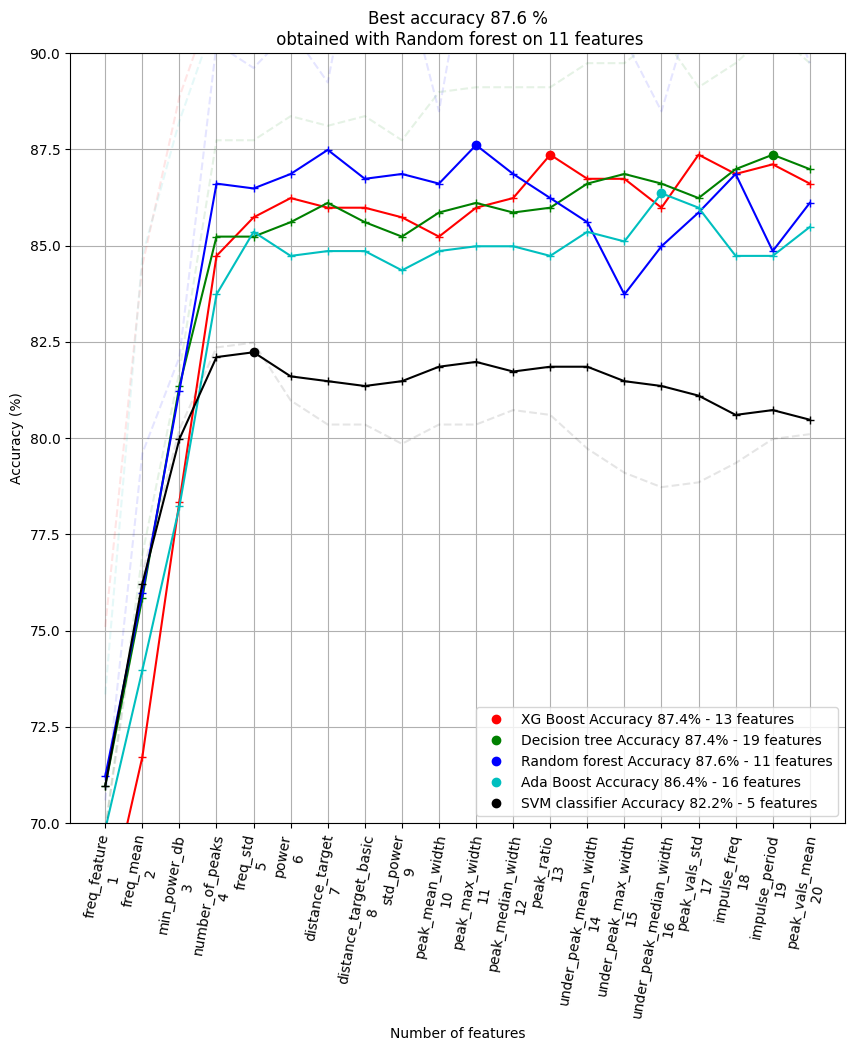

true_negative=368 non-menace samples were classified as non-menaces
false_positive=46 non-menaces were classified as menaces (False alarm)
false_negative=53 menaces were classified as non-menaces (problem = you're under attack and you didn't realize)
true_positive=332 menaces were classified as menaces correctly (you're under attack and you have detected it)


In [201]:
final_classification_plots(df_train, df_test, whiten_flag=True)


----------------

![](figures/final_classifier.png)

```bash
Confusion matrix
true_negative=368 non-menace samples were classified as non-menaces
false_positive=46 non-menaces were classified as menaces (False alarm)
false_negative=53 menaces were classified as non-menaces (problem = you're under attack and you didn't realize)
true_positive=332 menaces were classified as menaces correctly (you're under attack and you have detected it)
```

- Sur la courbe ci-dessus, on trace la précision de chaque détecteur en fonction du nombre de caractéristiques utilisées (on ajoute progressivement les caractéristiques). Le code et le graphe sont faits en sorte que l'on puisse retrouver le nom de la caractéristique utilisée.
- On remarque que l'utilisation de 4 caractéristiques `freq_feature` (*écart type(1/fréquence)/moyenne(1/fréquence)*), `freq_mean`, `min_power_db`, `number_of_peaks` permettent de dépasser la barre des 86% de précision. L'ajout du nombre de pics détectés permet de faire un saut par rapport au détecteur basique.
- En pointillés, on peut observer la précision du détecteur sur la base d'apprentissage. 
- On remarquera une matrice de confusion bien plus équilibrée entre faux positifs et faux négatifs... bien que je n'ai rien fait de spécial à ce sujet.


### Remarques finales 
> Les SVM ne fonctionnent bien pas si on ne "blanchie" pas les caractéristiques au préalable.

> Note 1: J'ai fait quelques essais d'incorporation de la formule de Friisn, sans grand succès.

> Note 2: Dans un de mes commits intermédiaires, j'avais réussi à atteindre 88.2% de précision grâce à xGboost. En pratique, je ne suis pas allé chercher à restaurer cette performance, ça n'a pas énormément de sens de s'acharner sur le problème car peut être qu'un peu de tuning des paramètres des détecteurs classiques permettrait de gagner un peu.
